In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Dict, Tuple
import pymongo

In [21]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv

load_dotenv()

mongo_url = os.getenv("MONGO_URL")
if not mongo_url:
    raise ValueError("MONGO_URL not set in .env")

client = MongoClient(mongo_url, serverSelectionTimeoutMS=5000)  # 5-second timeout
db = client["storage_simulation"]
collection = db["usage_logs"]

# Optional: test the connection
try:
    client.admin.command('ping')
    print("MongoDB connection successful")
except Exception as e:
    print(f"MongoDB connection failed: {e}")

MongoDB connection successful


In [22]:
# Configuration
# here we we use 4 hour aggrigation so 7 per day
tf.keras.mixed_precision.set_global_policy('mixed_float16')
HORIZONS = {   
    '3_month': 540,   # 30 days (6*30=180)  
}
SEQ_LENGTH = 42  # 7 days of historical data
BATCH_SIZE = 256
EPOCHS = 50

In [23]:
def load_and_preprocess_data() -> Dict[str, dict]:
    """Load and preprocess data with proper feature engineering"""
    raw_data = pd.DataFrame(list(collection.find()))
    raw_data = raw_data.drop(columns=['_id'])
    raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

    print("\n🔍 Data Diagnostics:")
    print(f"Total records: {len(raw_data)}")
    print("Unique directories:", raw_data['directory'].unique())

    processed = {}
    for directory in raw_data['directory'].unique():
        df = raw_data[raw_data['directory'] == directory].copy()
        df = df.sort_values('timestamp').set_index('timestamp')

        # Resample to 4-hour intervals
        # The 'directory' column is excluded from the mean calculation
        df = df[['storage_gb']].resample('4h').mean().ffill()

        # Feature engineering
        df['hour'] = df.index.hour
        df['time_sin'] = np.sin(2 * np.pi * df.index.hour/23)
        df['time_cos'] = np.cos(2 * np.pi * df.index.hour/23)

        # Scale storage_gb
        scaler = MinMaxScaler()
        df['scaled_gb'] = scaler.fit_transform(df[['storage_gb']])

        processed[directory] = {
            'data': df[['scaled_gb', 'time_sin', 'time_cos']],
            'original': df['storage_gb'],
            'scaler': scaler
        }

    return processed

In [24]:
def create_sequences(features: np.ndarray, targets: np.ndarray,
                    seq_length: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create sequences with validation"""
    X, y = [], []
    max_start = len(features) - seq_length - horizon
    if max_start < 0:
        return np.array([]), np.array([])

    for i in range(max_start + 1):
        X.append(features[i:i+seq_length])
        y.append(targets[i+seq_length:i+seq_length+horizon])
    return np.array(X), np.array(y)

In [25]:
#model
def build_model(input_shape: Tuple[int, int], output_steps: int) -> Model:
    """Optimized forecasting model architecture"""
    inputs = Input(shape=input_shape)

    # Temporal pattern extraction
    x = Conv1D(64, 3, activation='relu', padding='causal')(inputs)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(64)(x)

    # Prediction head
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_steps)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
    return model

In [26]:
import os
import joblib

def save_model_and_scaler(model, scaler, name):
    notebooks_dir = os.getcwd()

    # Ensure name is only a base name, not a path
    safe_name = os.path.basename(name)
    safe_name = safe_name.replace('/', '_').replace('\\', '_')

    # Create models directory
    models_dir = os.path.join(notebooks_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Final model path
    model_path = os.path.join(models_dir, f"{safe_name}_3_monthly_forecast_model.keras")
    model.save(model_path)
    print(f"Model saved at: {model_path}")

    # Create scalers directory
    scalers_dir = os.path.join(notebooks_dir, 'scalers')
    os.makedirs(scalers_dir, exist_ok=True)

    # Final scaler path
    scaler_path = os.path.join(scalers_dir, f"{safe_name}_3_monthly_scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved at: {scaler_path}")

In [27]:
def train_and_evaluate(data_dict: Dict) -> Tuple[Dict, Dict, Dict]:
    """Enhanced training with proper validation"""
    modeles = {}
    metrics = {}

    for name, data in data_dict.items():
        print(f"\n⚡ Processing {name}")
        df = data['data']
        scaler = data['scaler']

        # Prepare data
        total_points = len(df)
        test_size = HORIZONS['3_month'] + SEQ_LENGTH
        split_idx = total_points - test_size

        if split_idx < SEQ_LENGTH:
            print(f"⚠️ Insufficient data for {name}")
            continue

        # Create sequences
        X_train, y_train = create_sequences(
            df.values[:split_idx],
            df['scaled_gb'].values[:split_idx],
            SEQ_LENGTH, HORIZONS['3_month']
        )
        X_test, y_test = create_sequences(
            df.values[split_idx:],
            df['scaled_gb'].values[split_idx:],
            SEQ_LENGTH, HORIZONS['3_month']
        )

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"🚫 Sequence creation failed for {name}")
            continue

        # Model setup
        model = build_model((SEQ_LENGTH, 3), HORIZONS['3_month'])
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[
                EarlyStopping(patience=7, restore_best_weights=True),
                ModelCheckpoint(f'best_{name}.keras', save_best_only=True)
            ],
            verbose=1
        )

        # Generate predictions
        test_pred = model.predict(X_test)
        metrics[name] = {}

        # Calculate metrics for each horizon
        for horizon_name, steps in HORIZONS.items():
            preds = test_pred[:, :steps].reshape(-1, 1)
            true = y_test[:, :steps].reshape(-1, 1)

            # Inverse transform predictions
            preds_gb = scaler.inverse_transform(preds).reshape(-1, steps)
            true_gb = scaler.inverse_transform(true).reshape(-1, steps)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(true_gb, preds_gb))

            metrics[name][horizon_name] = {
                'rmse': rmse,
                'predictions': preds_gb[0],
                'true': true_gb[0]
            }
            

        modeles[name] = model

        save_model_and_scaler(model, scaler, name)


        

    return modeles, metrics

In [28]:
def plot_results(name: str, data: dict, metrics: dict):
    """Enhanced plotting with actual dates"""
    if name not in metrics:
        return

    plt.figure(figsize=(14, 7))
    original = data['original']

    # Get test period dates
    test_dates = original.index[-HORIZONS['3_month']:]

    for horizon in HORIZONS:
        if horizon not in metrics[name]:
            continue

        steps = HORIZONS[horizon]
        preds = metrics[name][horizon]['predictions'][:steps]
        true = metrics[name][horizon]['true'][:steps]
        dates = test_dates[:steps]

        plt.plot(dates, preds, label=f'{horizon} forecast')
        plt.fill_between(dates,
                        preds * 0.95,
                        preds * 1.05,
                        alpha=0.1)
        plt.plot(dates, true, '--', label='Actual')

    plt.title(f'{name} Storage Forecast')
    plt.ylabel('Storage (GB)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 Data Diagnostics:
Total records: 292508
Unique directories: ['/scratch' '/projects' '/customer' '/info']

⚡ Processing /scratch
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - loss: 0.2377 - val_loss: 0.1053
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 0.0848 - val_loss: 0.0413
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step - loss: 0.0443 - val_loss: 0.0347
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 450ms/step - loss: 0.0362 - val_loss: 0.0348
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - loss: 0.0328 - val_loss: 0.0264
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - loss: 0.0295 - val_loss: 0.0233
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - loss: 0.0290 - val_loss: 0.0211
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.0286 - val_loss: 0.0240
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 0.0277 - val_loss: 0.0246
Epoch 1

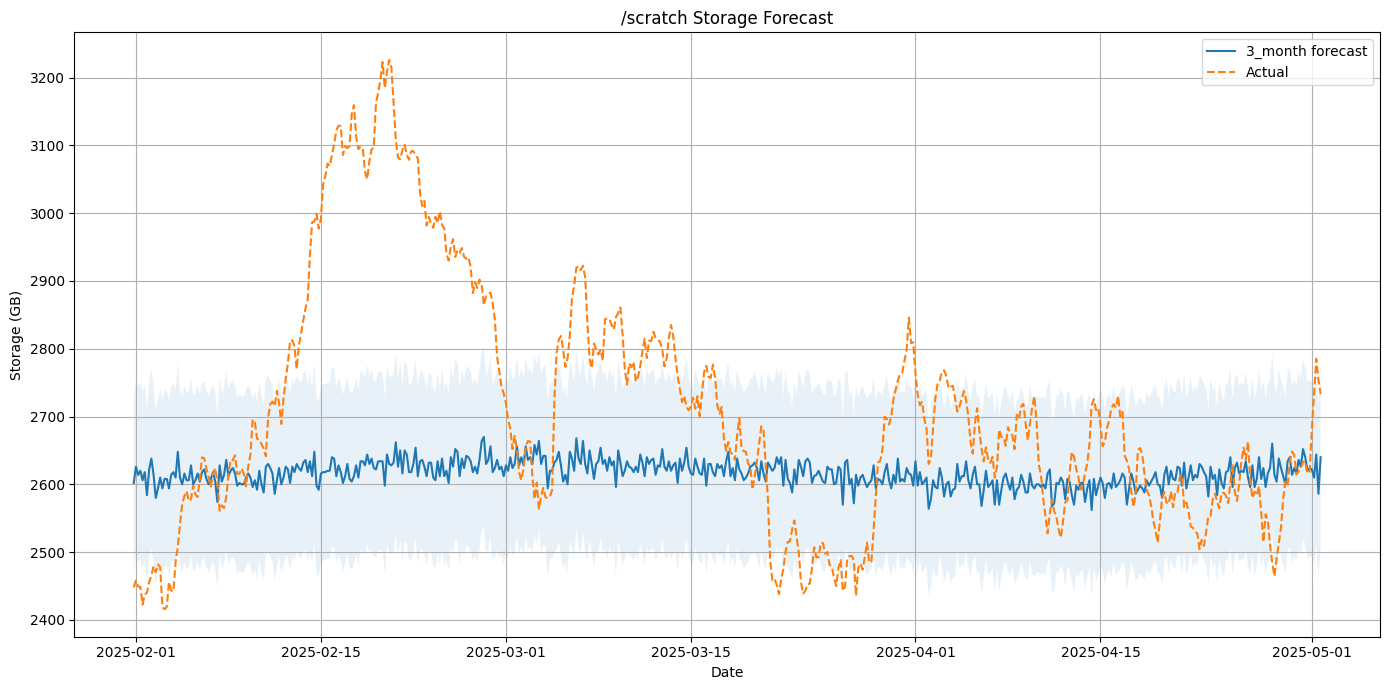


📊 /PROJECTS PERFORMANCE
3 Month      RMSE: 227.60 GB


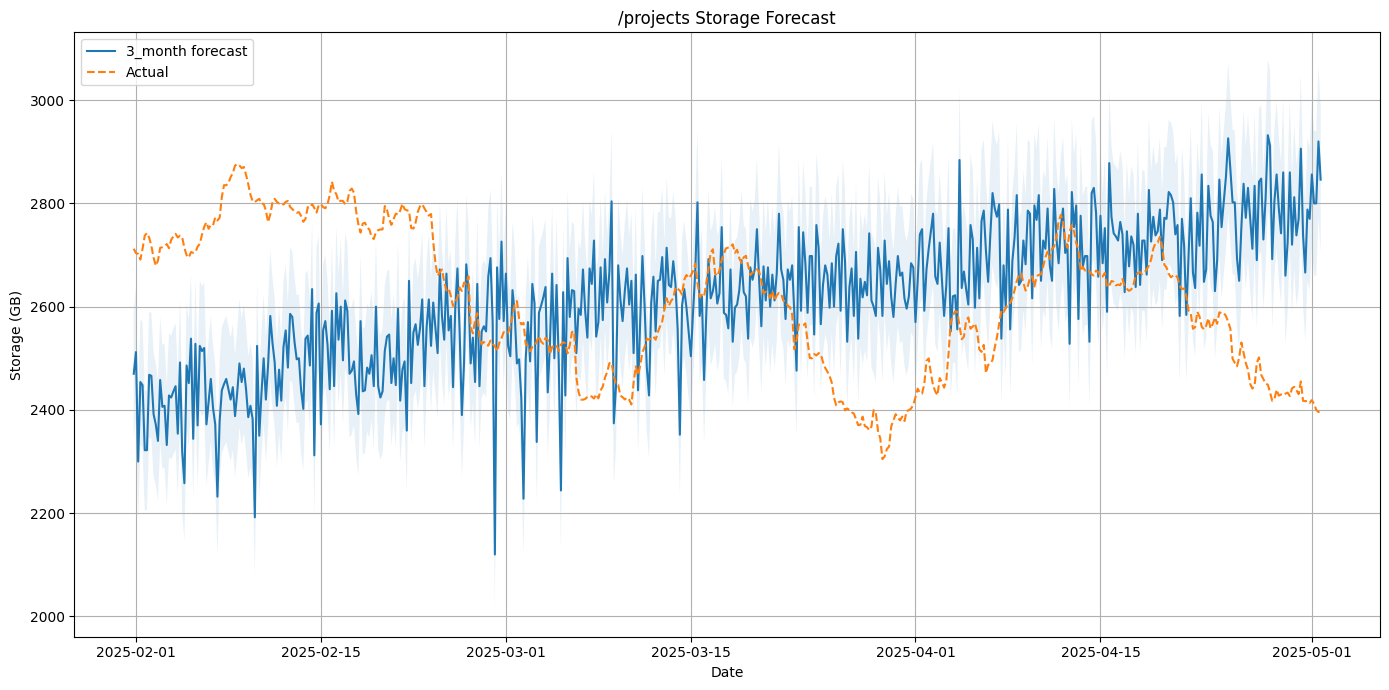


📊 /CUSTOMER PERFORMANCE
3 Month      RMSE: 58.36 GB


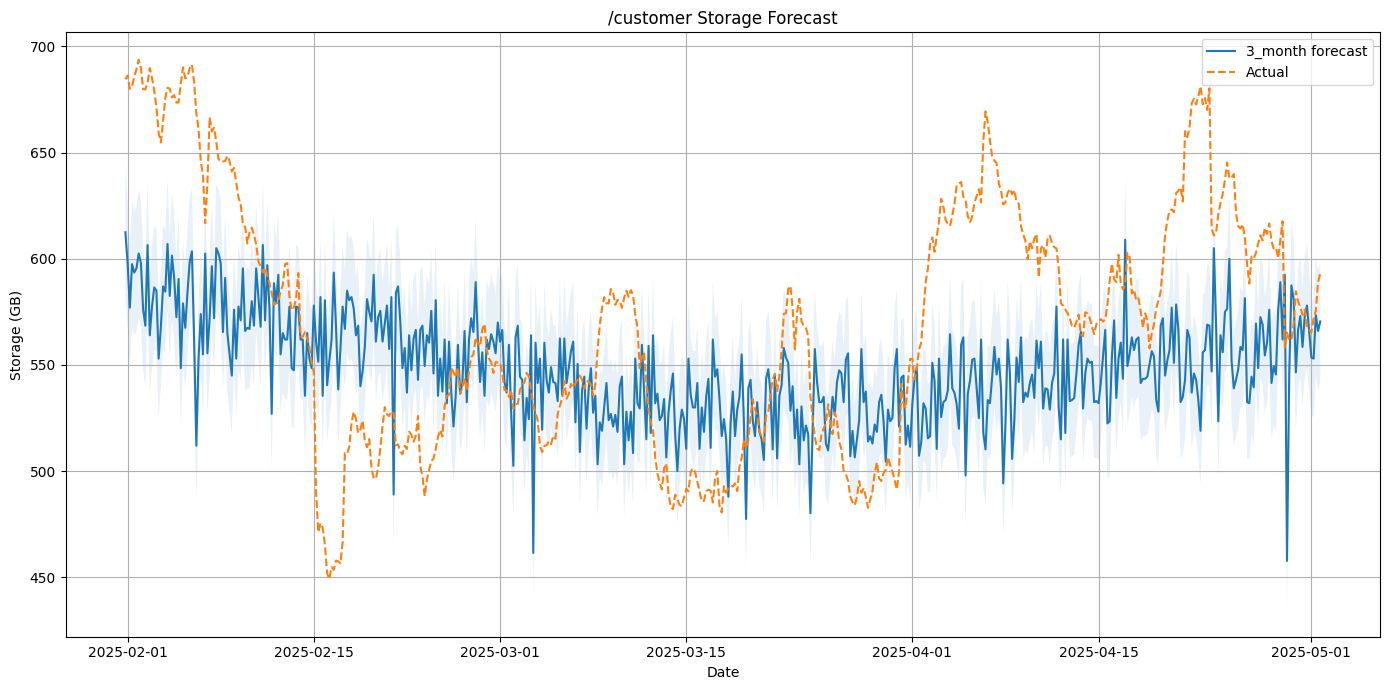


📊 /INFO PERFORMANCE
3 Month      RMSE: 43.81 GB


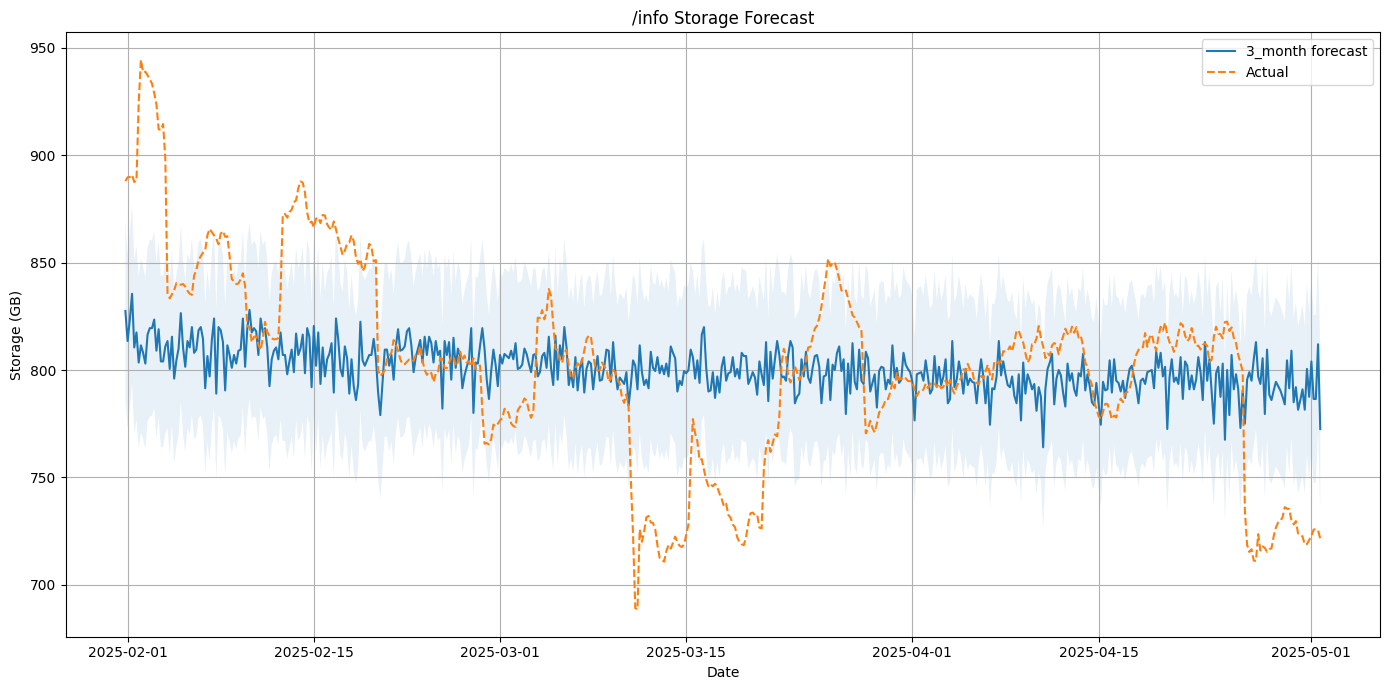

In [29]:
if __name__ == "__main__":
    data_dict = load_and_preprocess_data()
    models, metrics = train_and_evaluate(data_dict)

    for directory in data_dict:
        if directory in metrics:
            print(f"\n📊 {directory.upper()} PERFORMANCE")
            for horizon in HORIZONS:
                if horizon in metrics[directory]:
                    rmse = metrics[directory][horizon]['rmse']
                    print(f"{horizon.replace('_', ' ').title():<12} RMSE: {rmse:.2f} GB")
            plot_results(directory, data_dict[directory], metrics)